# M5 Forecasting Competition Source:

https://www.kaggle.com/c/m5-forecasting-accuracy/data?select=sales_train_evaluation.csv

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from numpy.random import seed
import os
import re
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import Input, LSTM, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from keras.models import Sequential

# Load Data

In [2]:
#load data
PATH = os.getcwd()
calendar = pd.read_csv(f'{PATH}/calendar.csv')
sales_train_validation = pd.read_csv(f'{PATH}/sales_train_validation.csv')
sell_prices = pd.read_csv(f'{PATH}/sell_prices.csv')

#print shape
print("shape of calendar: " + str(calendar.shape))
print("shape pf sales_train_validation: " + str(sales_train_validation.shape))  
print("shape pf sell_prices: " + str(sell_prices.shape))  

#inspect data
print(calendar.head)
print(sales_train_validation.head)
print(sell_prices.head)

shape of calendar: (1969, 14)
shape pf sales_train_validation: (30490, 1919)
shape pf sell_prices: (6841121, 4)
<bound method NDFrame.head of             date  wm_yr_wk    weekday  wday  month  year       d  \
0     2011-01-29     11101   Saturday     1      1  2011     d_1   
1     2011-01-30     11101     Sunday     2      1  2011     d_2   
2     2011-01-31     11101     Monday     3      1  2011     d_3   
3     2011-02-01     11101    Tuesday     4      2  2011     d_4   
4     2011-02-02     11101  Wednesday     5      2  2011     d_5   
...          ...       ...        ...   ...    ...   ...     ...   
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_na

# View Data

In [3]:
#view column values
print(pd.unique(calendar['event_name_1']))
print(pd.unique(calendar['event_name_2']))
print(pd.unique(sales_train_validation['state_id']))
print(pd.unique(sales_train_validation['store_id']))
print(pd.unique(sales_train_validation['dept_id']))


#number of products in each category
sales_train_validation[sales_train_validation.store_id == "CA_1"].groupby(["cat_id"]).agg({"item_id":"count"})


[nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']
[nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]
['CA' 'TX' 'WI']
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']


,item_id
cat_id,
FOODS,1437
HOBBIES,565
HOUSEHOLD,1047


# Data Pre-processing

In [4]:
# use store CA_1 data
sales_train_CA_1 = sales_train_validation[sales_train_validation.store_id == "CA_1"]
print("shape of sales_train_CA_1:" + str(sales_train_CA_1.shape))

# convert sales data to day + items as rows and demand as column
sales_train_validation_melt = pd.melt(sales_train_CA_1
                                      , id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
                                      , var_name='day'
                                      , value_name='sales')
print("shape of sales_train_validation_melt:" + str(sales_train_validation_melt.shape))
print(sales_train_validation_melt.head)


#merge data with calendar and sell price
merge_CA = pd.merge(sales_train_validation_melt, calendar, left_on="day", right_on="d", how="left")
merge_CA = pd.merge(merge_CA, sell_prices, left_on=["store_id", "item_id", "wm_yr_wk"],right_on=["store_id", "item_id", "wm_yr_wk"], how="left")

print("shape of merge_CA:" + str(merge_CA.shape))
print(merge_CA.columns)
#print(merge_CA.head)


shape of sales_train_CA_1:(3049, 1919)
shape of sales_train_validation_melt:(5832737, 8)
<bound method NDFrame.head of                                     id        item_id    dept_id   cat_id  \
0        HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1        HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2        HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3        HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4        HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                ...            ...        ...      ...   
5832732    FOODS_3_823_CA_1_validation    FOODS_3_823    FOODS_3    FOODS   
5832733    FOODS_3_824_CA_1_validation    FOODS_3_824    FOODS_3    FOODS   
5832734    FOODS_3_825_CA_1_validation    FOODS_3_825    FOODS_3    FOODS   
5832735    FOODS_3_826_CA_1_validation    FOODS_3_826    FOODS_3    FOODS   
5832736    FOODS_3_827_CA_1_valida

# Data Visualization : CA_1

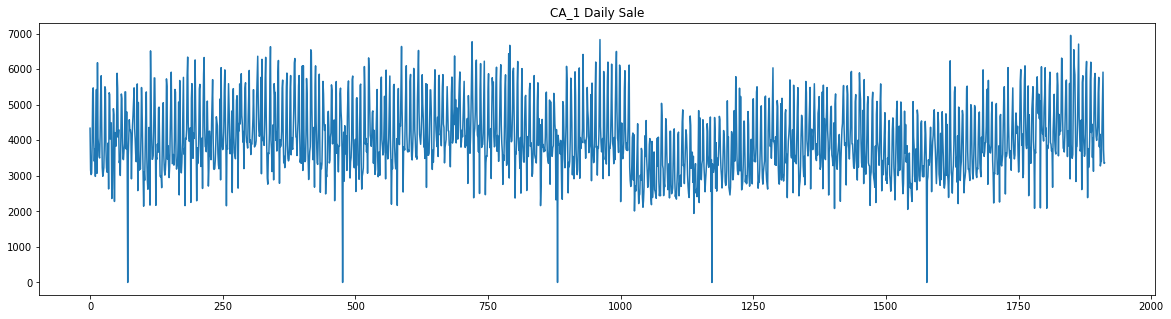

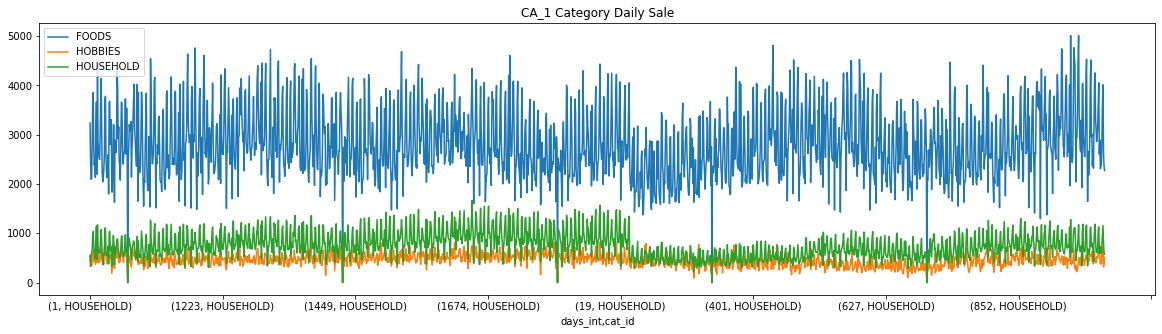

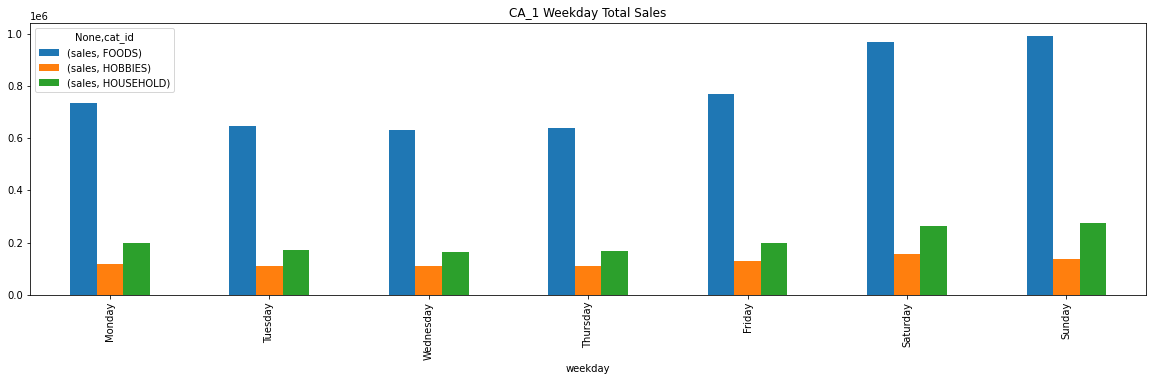

In [5]:

# create day index
days=[]
for i in merge_CA['day']:
    days.append(re.findall(r'\d+', i)[0])
merge_CA['days_int']=   days                
                               
# over all sales 
daily_sales = merge_CA.groupby(["days_int"]).agg({"sales":"sum"}).reset_index()
plt.figure(figsize=(20,5))
plt.title("CA_1 Daily Sale")
plt.plot(daily_sales['sales'].reset_index(drop=True))


# category sales
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title("CA_1 Category Daily Sale")
g = merge_CA.groupby(["days_int","cat_id"]).agg({"sales":"sum"})
g.groupby('cat_id')['sales'].plot(legend='True', ax = ax)


# weekday and weekend
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title("CA_1 Weekday Total Sales")
g2 = merge_CA.groupby(["weekday","cat_id"]).agg({"sales":"sum"}).unstack()
g2.reindex( ['Monday','Tuesday', 'Wednesday','Thursday', 'Friday','Saturday', 'Sunday']).plot.bar(ax = ax)



# Prepare Training and Testing Data for LSTM

most popular item : FOODS_3_090
most popular item sales: 127203


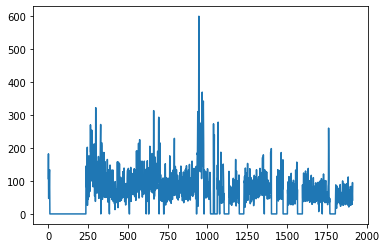

In [6]:
#select the most popular item as modeling example
sales_group = merge_CA.groupby(["item_id"]).agg({"sales":"sum"}).reset_index()
max_sale_item = sales_group.loc[sales_group['sales'].idxmax()].item_id
max_sales = sales_group.loc[sales_group['sales'].idxmax()].sales
print("most popular item : "+ max_sale_item) 
print("most popular item sales: "+ str(max_sales)) 

max_sale_product= merge_CA[merge_CA.item_id == max_sale_item]
input_df = max_sale_product["sales"]

#print(input_df.shape)

#plot the time series
plt.plot(input_df.reset_index(drop=True))

In [7]:
#scale data
def scale_data(df):
    data = df.values.reshape(-1, 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data)
    scaled_df =pd.Series(scaler.transform(data).flatten())
    return scaled_df, scaler


#split into training and testing set
def split_train_test(df, train_percentage):
    train_size = int(len(df) * train_percentage)
    train = df[:train_size]
    test = df[train_size:]
    return train, test
    

# build sequence data, use T past values to predict the next n_outputs values
def build_sequence_data(df, T, D, n_outputs):
    X = []
    Y = []
    for t in range(len(df) - T - n_outputs):
        x = df[t:t+T]
        X.append(x)
        y = np.array(df[t+T:t+T+n_outputs])
        Y.append(y)

    X = np.array(X).reshape(-1, T, D) # shape of data :  N x T x D
    Y = np.array(Y)
    N = len(X)
    #print("X.shape", X.shape, "Y.shape", Y.shape)

    return X,Y

In [8]:
#scale data
scaled_df, scaler = scale_data(input_df)

#split data
train_percentage = 0.8
train, test = split_train_test(scaled_df, train_percentage)
print(len(train))
print(len(test))

#build sequence data
T = 56 # use T past values to predict the next value
D = pd.DataFrame(scaled_df).shape[1]  # number of feature
n_outputs = 28 # number of forecasting steps

trainX,trainY = build_sequence_data(train,T,D,n_outputs)
testX,testY = build_sequence_data(test,T,D,n_outputs)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

1530
383
(1446, 56, 1)
(1446, 28)
(299, 56, 1)
(299, 28)


# Training LSTM model

Epoch 1/200
23/23 [==============================] - 1s 27ms/step - loss: 0.2671 - val_loss: 0.0171
Epoch 2/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0457 - val_loss: 0.0147
Epoch 3/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0410 - val_loss: 0.0150
Epoch 4/200
23/23 [==============================] - 0s 12ms/step - loss: 0.0397 - val_loss: 0.0148
Epoch 5/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0387 - val_loss: 0.0137
Epoch 6/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0376 - val_loss: 0.0135
Epoch 7/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0359 - val_loss: 0.0138
Epoch 8/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0330 - val_loss: 0.0128
Epoch 9/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0317 - val_loss: 0.0128
Epoch 10/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0314 - val_loss: 0.0124

23/23 [==============================] - 0s 11ms/step - loss: 0.0303 - val_loss: 0.0124
Epoch 83/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0303 - val_loss: 0.0129
Epoch 84/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0305 - val_loss: 0.0125
Epoch 85/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0303 - val_loss: 0.0122
Epoch 86/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0304 - val_loss: 0.0121
Epoch 87/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0303 - val_loss: 0.0121
Epoch 88/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0305 - val_loss: 0.0118
Epoch 89/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0304 - val_loss: 0.0121
Epoch 90/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0303 - val_loss: 0.0127
Epoch 91/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0302 - val_loss: 0.0135
Epo

23/23 [==============================] - 0s 10ms/step - loss: 0.0274 - val_loss: 0.0122
Epoch 163/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0274 - val_loss: 0.0117
Epoch 164/200
23/23 [==============================] - 0s 11ms/step - loss: 0.0272 - val_loss: 0.0123
Epoch 165/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0272 - val_loss: 0.0117
Epoch 166/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0273 - val_loss: 0.0129
Epoch 167/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0273 - val_loss: 0.0126
Epoch 168/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0271 - val_loss: 0.0127
Epoch 169/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0272 - val_loss: 0.0123
Epoch 170/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0270 - val_loss: 0.0114
Epoch 171/200
23/23 [==============================] - 0s 10ms/step - loss: 0.0271 - val_loss: 0

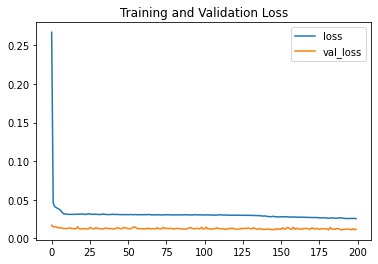

In [9]:
# set seed
seed(100)

# configuting LSTM model
model = Sequential()
model.add(LSTM(units = 8, kernel_initializer='normal', input_shape = (T, D)))
model.add(Dense(units = n_outputs))

model.compile(
  loss='mse',
  optimizer = Adam(lr= 0.01)
  #optimizer = Adadelta()
)

# train model using first half of the data
r = model.fit(
  trainX, trainY, 
  batch_size=64,
  epochs=200,
  validation_data=(testX, testY)
)

# plot training and validation loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


# Make Forecast and Evaluate Results

In [10]:
# make forecast using test data
def forecasts(model, testX, T, D):
    forecasts = list()
    for x in testX:
        # make forecast
        forecast = model.predict(x.reshape(1, T, D))
        # store the forecast
        forecasts.append(forecast)
    return forecasts

#inverse scaled data
def scale_inverse(arrays, scaler, n_outputs):
    inverted = list()
    for array in arrays:
        array = array.reshape(-1, n_outputs)
        inv_scale = scaler.inverse_transform(array)
        inverted.append(inv_scale)
    return np.array(inverted).reshape(-1,n_outputs)

#evaluate forecasts
def evaluate_forecasts(testY, forecasts, T, n_outputs):
    abs_error={}
    for i in range(n_outputs):
        
        actual = [row[i] for row in testY]
        predicted = [forecast[i] for forecast in forecasts]
        
        #rmse = sqrt(mean_squared_error(actual, predicted))
        #print('t+%d RMSE: %f' % ((i+1), rmse))
        
        mae = np.mean(mean_absolute_error(actual, predicted))
        print('t+%d MAE: %f' % ((i+1), mae))
        
        #plot boxplot of absolute error for each step
        error = np.absolute(np.subtract(np.array(actual), np.array(predicted)))
        index = [i+1]*len(error)
        #create a dataframe of errors of each step
        if "step" in abs_error:
              abs_error["step"] += index
        else:
              abs_error["step"] =  index

        if "error" in abs_error:
              abs_error["error"] +=  error.tolist()
        else:
              abs_error["error"] = error.tolist()
    
    pd.DataFrame(abs_error).boxplot(column=['error'], by=['step'], figsize = (20,5), )


                
#based on the testing ressults, plot the forecast values from n_previous days 
def plot_forecast_results(testX, inverted_forecast, plot_n_previous_forecast, scaler, T,inverted_textY=None):
    
    # plot the entire dataset in blue
    inverted_testX = scaler.inverse_transform(testX[-plot_n_previous_forecast].reshape(-1,1))
    
        # can plot the graph with or without actual future values
    if inverted_textY is not None:
        actual = np.concatenate((inverted_testX.ravel(), inverted_textY[-plot_n_previous_forecast]))
    else:
        actual = inverted_testX.ravel()
    
    plt.figure(figsize=(20,5))
    plt.plot(actual, label='actual')
    
    # plot the forecasts in red
    n_outputs = len(inverted_forecast[-plot_n_previous_forecast])
    
    off_s = T
    off_e = off_s + n_outputs
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = inverted_forecast[-plot_n_previous_forecast].flatten()
    plt.plot(xaxis, yaxis, color='red', label='forecast')
    plt.xticks(range(0, len(actual)))
    plt.legend()
    plt.title("Forecasts for the next 28 days")

    plt.show()

t+1 MAE: 20.995667
t+2 MAE: 21.449080
t+3 MAE: 20.331124
t+4 MAE: 19.766782
t+5 MAE: 20.304814
t+6 MAE: 21.094160
t+7 MAE: 21.157351
t+8 MAE: 22.277504
t+9 MAE: 25.609476
t+10 MAE: 23.662386
t+11 MAE: 23.474635
t+12 MAE: 24.284892
t+13 MAE: 24.027610
t+14 MAE: 23.067062
t+15 MAE: 24.218852
t+16 MAE: 27.298640
t+17 MAE: 24.045425
t+18 MAE: 24.391517
t+19 MAE: 26.829995
t+20 MAE: 23.683153
t+21 MAE: 23.929504
t+22 MAE: 23.710176
t+23 MAE: 29.924884
t+24 MAE: 26.800367
t+25 MAE: 27.472481
t+26 MAE: 26.367489
t+27 MAE: 24.292974
t+28 MAE: 25.712422


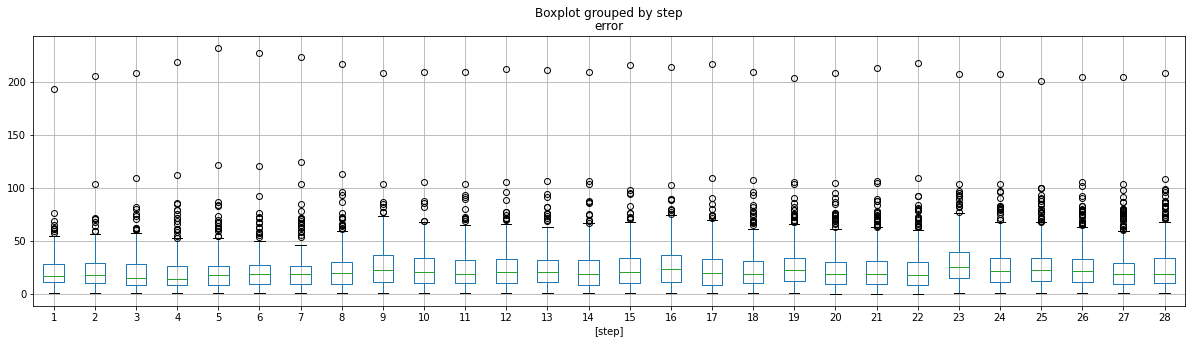

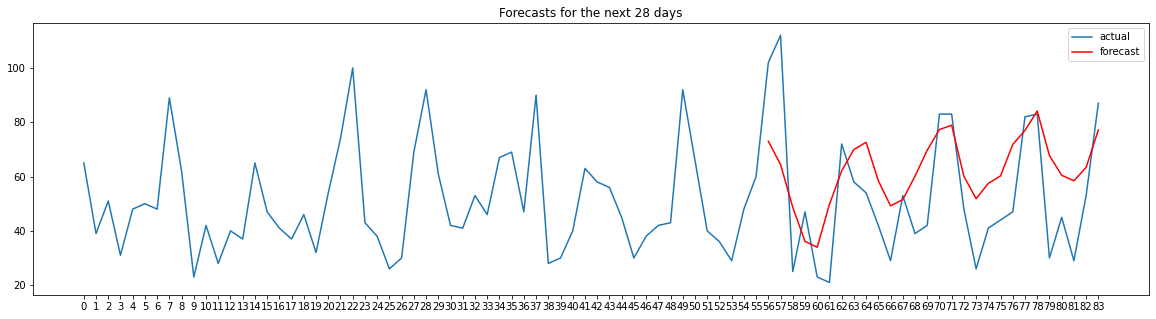

In [11]:
# forecast and evaluate using rmse/ mae
forecast = forecasts(model, testX, T, D)
inverted_forecast = scale_inverse(forecast,scaler,n_outputs)
inverted_actual = scale_inverse(testY,scaler,n_outputs)
evaluate_forecasts(inverted_actual, inverted_forecast, T, n_outputs)

# plot forecasting result for the next 28 days based on 28 previous days
# could plot with or without inverted_actual
plot_n_previous_forecast = 2
plot_forecast_results(testX, inverted_forecast, plot_n_previous_forecast , scaler, T,inverted_actual)


(355, 1)


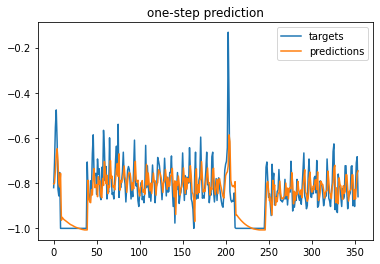

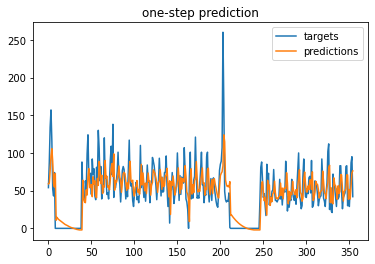

In [428]:
'''
# One-step forecast using true targets

outputs = model.predict(testX)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(testY, label='targets')
plt.plot(predictions, label='predictions')
plt.title("one-step prediction")
plt.legend()
plt.show()


plt.plot(scaler.inverse_transform(np.array(testY).reshape(-1,1)), label='targets')
plt.plot(scaler.inverse_transform(np.array(predictions).reshape(-1,1)), label='predictions')
plt.title("one-step prediction")
plt.legend()
plt.show()


# Multi-step forecast
validation_target = testY[-T:] #second half of validation target
validation_predictions = []

# first validation input
last_x = testX[-T] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
    # update the predictions list
    validation_predictions.append(p)
  
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

#plot result  
#plt.plot(validation_target, label='forecast scaled target')
plt.plot(validation_predictions, label='forecast scaled prediction')
plt.legend()
plt.show()

#plot inversed result  
#plt.plot(inverse_scale(input_df,validation_target), label='forecast inversed target')
plt.plot(scaler.inverse_transform(np.array(validation_predictions).reshape(-1,1)), label='forecast inversed prediction')
plt.legend()
plt.show()

'''

# multi-dimension input LSTM

In [37]:
# create dummy variableㄋ : weekday, event_name
multi_inputs = max_sale_product[['sales','weekday','event_name_1']]
dummy_df = pd.get_dummies(multi_inputs).reset_index(drop = True)
#print(dummy_df)
print(dummy_df.shape)

# scale sales column
scaled_df, scaler = scale_data(dummy_df['sales'])
dummy_df['sales'] =  scaled_df
dummy_df= dummy_df[['sales' ,'weekday_Monday','weekday_Tuesday', 'weekday_Wednesday',
                    'weekday_Thursday', 'weekday_Friday', 'weekday_Saturday','weekday_Sunday' ]]   

#split data
train_percentage = 0.8
train, test = split_train_test(dummy_df, train_percentage)
print(len(train))
print(len(test))


#build sequence data
def build_multidimension_seqence_data(df, T, D, n_outputs):
    target = df['sales'].values
    N = len(df) - T - n_outputs
    X = np.zeros((N, T, D))
    Y = []

    for t in range(N):
        X[t, :, :] = df[t:t+T]
        y = np.array(target[t+T:t+T+n_outputs])
        Y.append(y)
    Y = np.array(Y)
    
    return X, Y

T = 56 # use T past values to predict the next value
D = pd.DataFrame(dummy_df).shape[1]  # number of feature
n_outputs = 28 # number of forecasting steps

trainX,trainY = build_multidimension_seqence_data(train,T,D,n_outputs)
testX,testY = build_multidimension_seqence_data(test,T,D,n_outputs)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1913, 38)
1530
383
(1446, 56, 8)
(1446, 28)
(299, 56, 8)
(299, 28)


In [36]:
print(dummy_df.head)

<bound method NDFrame.head of          sales  weekday_Friday  weekday_Monday  weekday_Saturday  \
0    -0.642738               0               0                 1   
1    -0.392321               0               0                 0   
2    -0.843072               0               1                 0   
3    -0.843072               0               0                 0   
4    -0.792988               0               0                 0   
...        ...             ...             ...               ...   
1908 -0.903172               0               0                 0   
1909 -0.823038               0               0                 0   
1910 -0.709516               1               0                 0   
1911 -0.682805               0               0                 1   
1912 -0.859766               0               0                 0   

      weekday_Sunday  weekday_Thursday  weekday_Tuesday  weekday_Wednesday  \
0                  0                 0                0                  0 

Epoch 1/120
91/91 [==============================] - 1s 14ms/step - loss: 0.0565 - val_loss: 0.0131
Epoch 2/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0336 - val_loss: 0.0136
Epoch 3/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0320 - val_loss: 0.0120
Epoch 4/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0307 - val_loss: 0.0142
Epoch 5/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0308 - val_loss: 0.0129
Epoch 6/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0302 - val_loss: 0.0148
Epoch 7/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0296 - val_loss: 0.0120
Epoch 8/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0297 - val_loss: 0.0126
Epoch 9/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0334 - val_loss: 0.0161
Epoch 10/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0326 - val_loss: 0.0119

91/91 [==============================] - 1s 10ms/step - loss: 0.0272 - val_loss: 0.0122
Epoch 83/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0271 - val_loss: 0.0127
Epoch 84/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0272 - val_loss: 0.0124
Epoch 85/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0279 - val_loss: 0.0131
Epoch 86/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0270 - val_loss: 0.0158
Epoch 87/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0273 - val_loss: 0.0111
Epoch 88/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0265 - val_loss: 0.0112
Epoch 89/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0291 - val_loss: 0.0112
Epoch 90/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0284 - val_loss: 0.0123
Epoch 91/120
91/91 [==============================] - 1s 10ms/step - loss: 0.0270 - val_loss: 0.0123
Epo

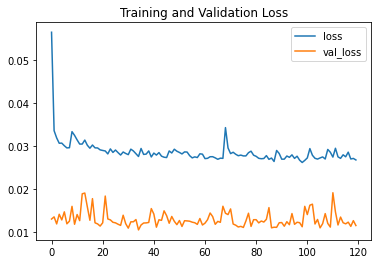

In [38]:
# set seed
seed(100)

# configuting LSTM model
model = Sequential()
model.add(LSTM(units = 16, kernel_initializer='normal', input_shape = (T, D)))
model.add(Dense(units = n_outputs))

model.compile(
  loss='mse',
  optimizer = Adam(lr= 0.1)
  #optimizer = Adadelta()
)

# train model using first half of the data
r = model.fit(
  trainX, trainY, 
  batch_size=16,
  epochs=120,
  validation_data=(testX, testY)
)

# plot training and validation loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()



t+1 MAE: 18.689175
t+2 MAE: 19.837567
t+3 MAE: 28.433789
t+4 MAE: 19.944505
t+5 MAE: 19.764529
t+6 MAE: 19.763703
t+7 MAE: 20.586015
t+8 MAE: 21.379628
t+9 MAE: 28.214077
t+10 MAE: 22.925241
t+11 MAE: 21.162067
t+12 MAE: 27.178001
t+13 MAE: 21.269470
t+14 MAE: 21.226722
t+15 MAE: 24.887188
t+16 MAE: 20.812446
t+17 MAE: 20.553683
t+18 MAE: 21.405897
t+19 MAE: 22.991351
t+20 MAE: 21.612192
t+21 MAE: 24.651597
t+22 MAE: 24.381959
t+23 MAE: 27.860181
t+24 MAE: 20.993409
t+25 MAE: 20.955022
t+26 MAE: 24.376842
t+27 MAE: 28.864036
t+28 MAE: 25.214973


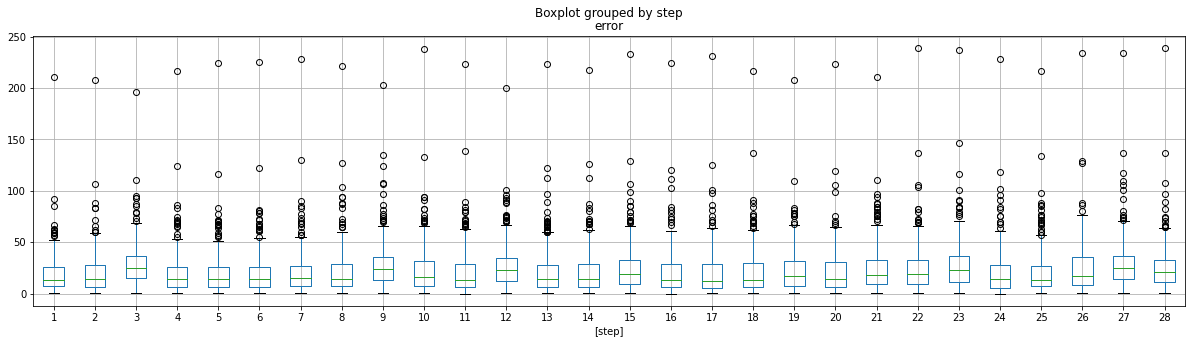

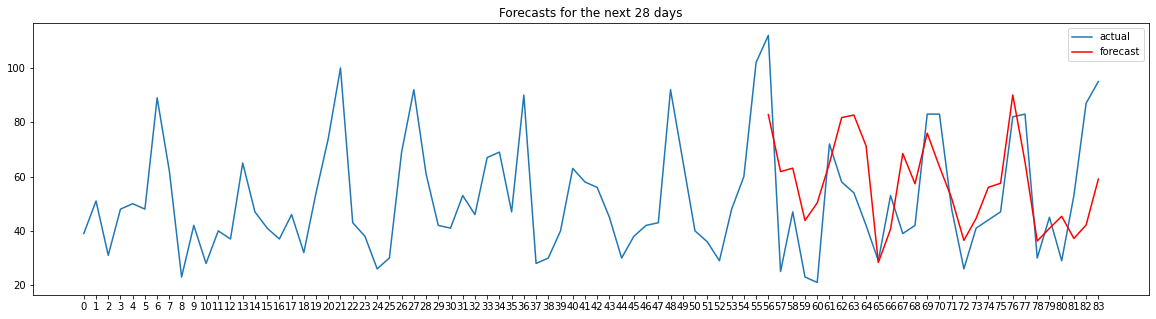

In [39]:
# forecast and evaluate using rmse/ mae
forecast = forecasts(model, testX, T, D)
inverted_forecast = scale_inverse(forecast,scaler,n_outputs)
inverted_actual = scale_inverse(testY,scaler,n_outputs)
evaluate_forecasts(inverted_actual, inverted_forecast, T, n_outputs)

# plot forecasting result for the next 28 days based on 28 previous days
# could plot with or without inverted_actual
plot_n_previous_forecast = 1
plot_forecast_results(testX[:,:,0], inverted_forecast, plot_n_previous_forecast , scaler, T, inverted_actual)
